## Import Packages


In [26]:
from pathlib import Path
import os.path
from IPython.display import Image, display
from sklearn.model_selection import train_test_split

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
import os

## Dataset

In [27]:
image_dir = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [28]:
#Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

## Explore the Data

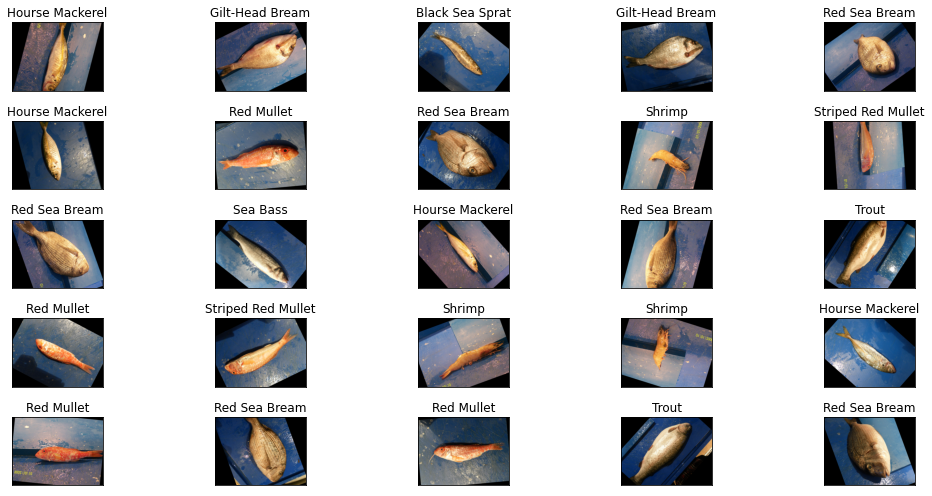

In [29]:
# Display 25 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [30]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [31]:
len(train_df)

7200

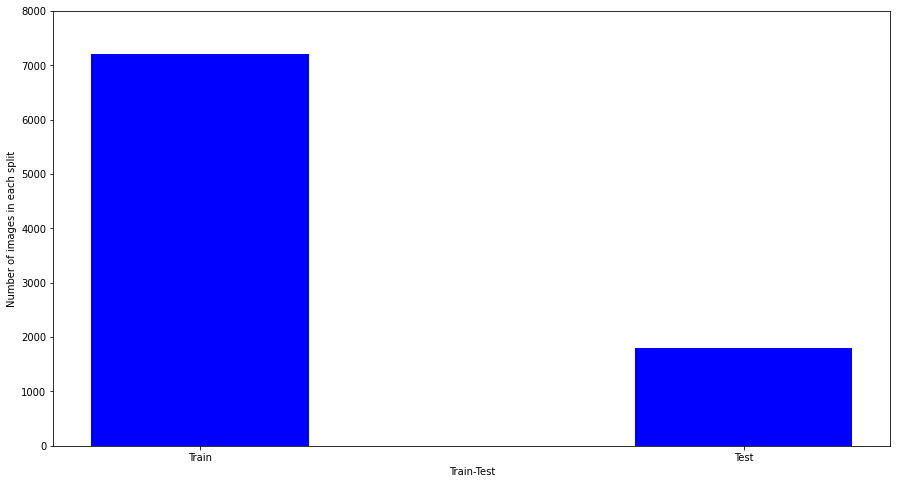

In [32]:
div = ['Train', 'Test']

values = [len(train_df), len(test_df)]

fig = plt.figure(figsize = (15, 8)) 
  
# creating the bar plot 
plt.bar(div, values, color ='blue',  
        width = 0.4) 
plt.ylim(0, 8000, 100)  
plt.xlabel("Train-Test") 
plt.ylabel("Number of images in each split") 
plt.show() 

## Data Preprocessing

In [33]:
train_generator = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.xception.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.xception.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


## Building Model

In [34]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (299, 299)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [35]:
image_batch, label_batch = next(iter(train_images))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 10, 10, 2048)


In [36]:
base_model.trainable = False

In [37]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [39]:
prediction_layer = tf.keras.layers.Dense(9)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 9)


In [40]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [41]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 18441     
Total params: 20,879,921
Trainable params: 18,441
Non-trainable params: 20,861,480
_________________________________________________________________


In [43]:
len(model.trainable_variables)

2

## Tensorboard

In [44]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [45]:
import datetime
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [46]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training

In [47]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_images)

90/90 [==============================] - 23s 242ms/step - loss: 2.2929 - accuracy: 0.0710


In [48]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.29
initial accuracy: 0.06


In [49]:
history = model.fit(train_images,
                    epochs=initial_epochs,
                    validation_data=val_images)
                    #callbacks = [tensorboard_callback])

Epoch 1/10
360/360 [==============================] - 114s 310ms/step - loss: 1.5969 - accuracy: 0.6651 - val_loss: 1.0947 - val_accuracy: 0.9271
Epoch 2/10
360/360 [==============================] - 90s 249ms/step - loss: 0.8478 - accuracy: 0.9273 - val_loss: 0.6585 - val_accuracy: 0.9472
Epoch 3/10
360/360 [==============================] - 89s 248ms/step - loss: 0.5484 - accuracy: 0.9510 - val_loss: 0.4578 - val_accuracy: 0.9604
Epoch 4/10
360/360 [==============================] - 89s 248ms/step - loss: 0.4008 - accuracy: 0.9616 - val_loss: 0.3486 - val_accuracy: 0.9681
Epoch 5/10
360/360 [==============================] - 89s 249ms/step - loss: 0.3153 - accuracy: 0.9635 - val_loss: 0.2788 - val_accuracy: 0.9743
Epoch 6/10
360/360 [==============================] - 89s 248ms/step - loss: 0.2570 - accuracy: 0.9719 - val_loss: 0.2315 - val_accuracy: 0.9778
Epoch 7/10
360/360 [==============================] - 89s 248ms/step - loss: 0.2168 - accuracy: 0.9750 - val_loss: 0.1968 - val_a

## Evaluating Accuracy and Loss for the Model

Text(0.5, 1.0, 'Training and Validation Accuracy')

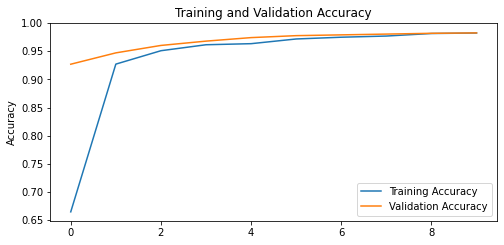

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

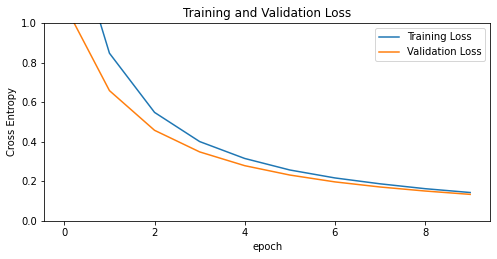

In [53]:
plt.figure(figsize= (8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [54]:
base_model.trainable = True

In [55]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


In [57]:
#base_learning_rate = 1e-5

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 18441     
Total params: 20,879,921
Trainable params: 9,496,785
Non-trainable params: 11,383,136
_________________________________________________________________


In [59]:
len(model.trainable_variables)

41

In [60]:
es = EarlyStopping(
    monitor='val_loss', patience=5, verbose=0, mode='min'
)

In [61]:
mc = ModelCheckpoint('best_xception_fish_classifier.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [67]:
#initial_epochs = 50
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_images,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_images,
                         callbacks = [es, mc, tensorboard_callback])

#model.save('/content/mobilenet_v2')

Epoch 10/20
360/360 [==============================] - 100s 267ms/step - loss: 0.0543 - accuracy: 0.9868 - val_loss: 0.0143 - val_accuracy: 0.9937

Epoch 00010: val_accuracy improved from -inf to 0.99375, saving model to best_xception_fish_classifier.h5
Epoch 11/20
360/360 [==============================] - 96s 266ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 0.0079 - val_accuracy: 0.9979

Epoch 00011: val_accuracy improved from 0.99375 to 0.99792, saving model to best_xception_fish_classifier.h5
Epoch 12/20
360/360 [==============================] - 96s 266ms/step - loss: 9.6836e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9986

Epoch 00012: val_accuracy improved from 0.99792 to 0.99861, saving model to best_xception_fish_classifier.h5
Epoch 13/20
360/360 [==============================] - 95s 264ms/step - loss: 2.3357e-04 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 0.9965

Epoch 00013: val_accuracy did not improve from 0.99861
Epoch 14/20
360/360 [===

In [68]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

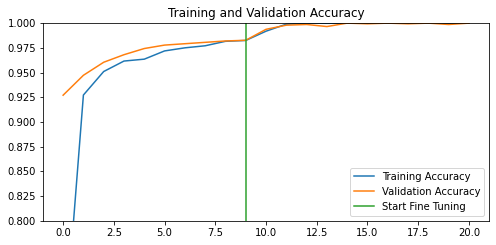

In [69]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

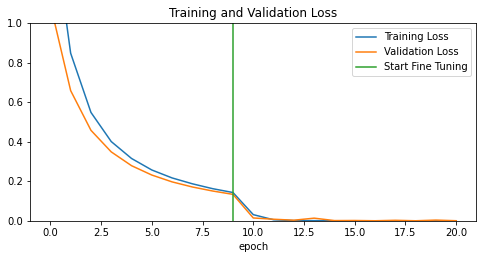

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [74]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 1405), started 0:25:27 ago. (Use '!kill 1405' to kill it.)

In [75]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00000
Test Accuracy: 100.00%


In [76]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Black Sea Sprat', 'Striped Red Mullet', 'Trout', 'Red Mullet', 'Gilt-Head Bream']


In [77]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       229
   Gilt-Head Bream       1.00      1.00      1.00       189
   Hourse Mackerel       1.00      1.00      1.00       209
        Red Mullet       1.00      1.00      1.00       196
     Red Sea Bream       1.00      1.00      1.00       181
          Sea Bass       1.00      1.00      1.00       189
            Shrimp       1.00      1.00      1.00       197
Striped Red Mullet       1.00      1.00      1.00       188
             Trout       1.00      1.00      1.00       222

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



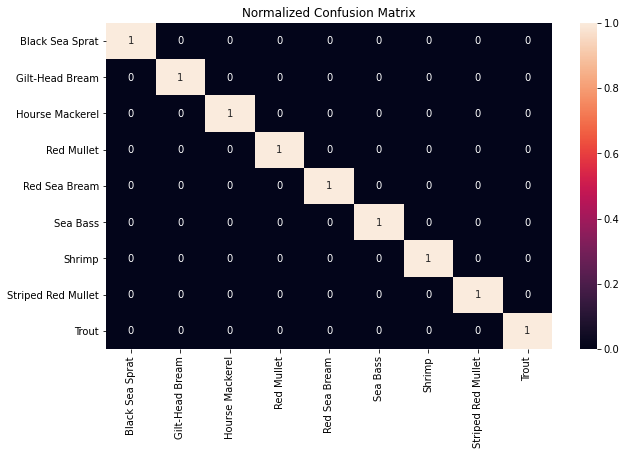

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

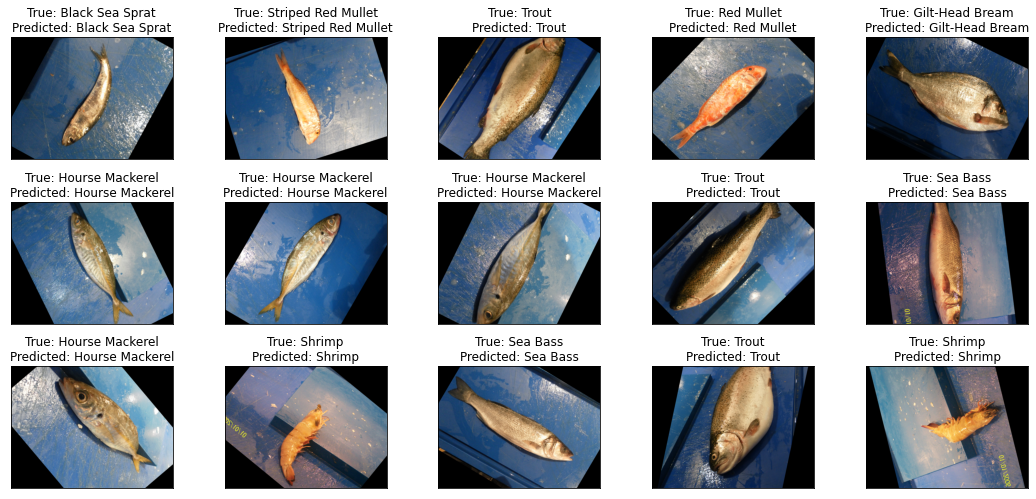

In [79]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()